Unique labels: [0 1 2 3 4]
Label distribution:
 diagnosis
0    1017
2     347
1     270
3      75
4      35
Name: count, dtype: int64


/tmp/ipykernel_36/2508848155.py:110: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Using 2 GPUs via DataParallel.
Starting training for 20 epochs. Steps/epoch=44, LR=0.0001


Epoch 1/20 | Train Loss: 1.1948, Train Acc: 0.5935 | Val Loss: 1.0340, Val Acc: 0.6590
✅ New best model saved. Best Val Acc: 0.6590


Epoch 2/20 | Train Loss: 0.9727, Train Acc: 0.7068 | Val Loss: 0.8730, Val Acc: 0.7479
✅ New best model saved. Best Val Acc: 0.7479


Epoch 3/20 | Train Loss: 0.8591, Train Acc: 0.7599 | Val Loss: 0.8889, Val Acc: 0.7421


Epoch 4/20 | Train Loss: 0.8002, Train Acc: 0.7892 | Val Loss: 0.7888, Val Acc: 0.7966
✅ New best model saved. Best Val Acc: 0.7966


Epoch 5/20 | Train Loss: 0.7557, Train Acc: 0.8172 | Val Loss: 0.8079, Val Acc: 0.7851


Epoch 6/20 | Train Loss: 0.7151, Train Acc: 0.8380 | Val Loss: 0.8032, Val Acc: 0.7765


Epoch 7/20 | Train Loss: 0.6744, Train Acc: 0.8602 | Val Loss: 0.8348, Val Acc: 0.7564


Epoch 8/20 | Train Loss: 0.6410, Train Acc: 0.8781 | Val Loss: 0.8303, Val Acc: 0.7650


Epoch 9/20 | Train Loss: 0.5972, Train Acc: 0.8989 | Val Loss: 0.8008, Val Acc: 0.7593


Epoch 10/20 | Train Loss: 0.5391, Train Acc: 0.9398 | Val Loss: 0.8396, Val Acc: 0.7794


Epoch 11/20 | Train Loss: 0.4995, Train Acc: 0.9584 | Val Loss: 0.9028, Val Acc: 0.7393


Epoch 12/20 | Train Loss: 0.4796, Train Acc: 0.9656 | Val Loss: 0.8687, Val Acc: 0.7536


Epoch 13/20 | Train Loss: 0.4484, Train Acc: 0.9792 | Val Loss: 0.9374, Val Acc: 0.7450


Epoch 14/20 | Train Loss: 0.4318, Train Acc: 0.9885 | Val Loss: 0.8962, Val Acc: 0.7736


Epoch 15/20 | Train Loss: 0.4179, Train Acc: 0.9935 | Val Loss: 0.9141, Val Acc: 0.7622


Epoch 16/20 | Train Loss: 0.4114, Train Acc: 0.9978 | Val Loss: 0.9533, Val Acc: 0.7393


Epoch 17/20 | Train Loss: 0.4142, Train Acc: 0.9971 | Val Loss: 0.9288, Val Acc: 0.7708


Epoch 18/20 | Train Loss: 0.4141, Train Acc: 0.9950 | Val Loss: 0.9361, Val Acc: 0.7307


Epoch 19/20 | Train Loss: 0.4124, Train Acc: 0.9950 | Val Loss: 0.9209, Val Acc: 0.7708


Epoch 20/20 | Train Loss: 0.4095, Train Acc: 0.9964 | Val Loss: 0.9227, Val Acc: 0.7708

✅ Training complete. Best Val Acc: 0.7966

📊 Accuracy: 0.7966
📊 F1 Score: 0.7340
📊 Precision: 0.8299
📊 Recall: 0.7966

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.98      0.89       204
           1       1.00      0.04      0.07        54
           2       0.75      0.86      0.80        69
           3       0.75      1.00      0.86        15
           4       1.00      0.29      0.44         7

    accuracy                           0.80       349
   macro avg       0.86      0.63      0.61       349
weighted avg       0.83      0.80      0.73       349



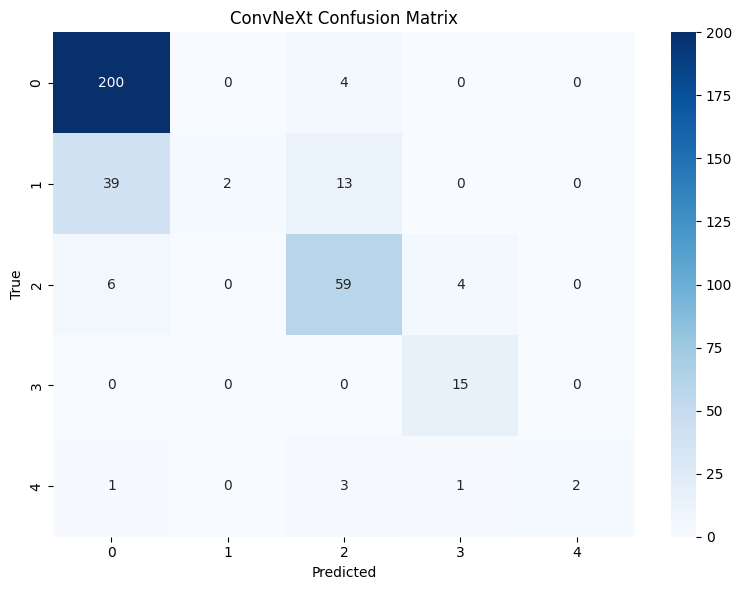

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import pandas as pd
from PIL import Image
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Config
# ----------------------------
IMG_SIZE = 380
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4   # lowered learning rate
SEED = 42

DATA_CSV = "/kaggle/input/messidor2preprocess/messidor_data.csv"
IMG_DIR = "/kaggle/input/messidor2preprocess/messidor-2/messidor-2/preprocess"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)

# ----------------------------
# Dataset
# ----------------------------
class MessidorDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['id_code']       # already includes ".png"
        label = int(row['diagnosis'])
        img_path = os.path.join(self.img_dir, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


if __name__ == "__main__":
    # ----------------------------
    # Data Prep
    # ----------------------------
    df = pd.read_csv(DATA_CSV)

    # ✅ Ensure labels are ints 0–4
    if df["diagnosis"].dtype != "int64" and df["diagnosis"].dtype != "int32":
        label_map = {cls: i for i, cls in enumerate(sorted(df["diagnosis"].unique()))}
        df["diagnosis"] = df["diagnosis"].map(label_map)

    print("Unique labels:", df["diagnosis"].unique())
    print("Label distribution:\n", df["diagnosis"].value_counts())

    train_df, val_df = train_test_split(
        df, test_size=0.2, stratify=df["diagnosis"], random_state=SEED
    )

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

    train_dataset = MessidorDataset(train_df, IMG_DIR, transform=train_transform)
    val_dataset = MessidorDataset(val_df, IMG_DIR, transform=val_transform)

    # ❌ Disabled WeightedRandomSampler for now
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=4, pin_memory=True)

    # ----------------------------
    # Model
    # ----------------------------
    model = timm.create_model("convnext_base", pretrained=True, num_classes=5)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs via DataParallel.")
        model = nn.DataParallel(model)
    model = model.to(DEVICE)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler()

    # ----------------------------
    # Training
    # ----------------------------
    best_acc = 0.0
    print(f"Starting training for {EPOCHS} epochs. Steps/epoch={len(train_loader)}, LR={LR}")

    for epoch in range(EPOCHS):
        model.train()
        train_loss, train_preds, train_targets = 0, [], []
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)

        for imgs, labels in train_bar:
            imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            preds = outputs.argmax(1).detach().cpu().numpy()
            train_preds.extend(preds)
            train_targets.extend(labels.cpu().numpy())
            train_bar.set_postfix(loss=loss.item())

        train_acc = accuracy_score(train_targets, train_preds)

        # ----------------------------
        # Validation
        # ----------------------------
        model.eval()
        val_loss, val_preds, val_targets = 0, [], []
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False)
        with torch.no_grad():
            for imgs, labels in val_bar:
                imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
                with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(1).detach().cpu().numpy()
                val_preds.extend(preds)
                val_targets.extend(labels.cpu().numpy())
                val_bar.set_postfix(loss=loss.item())

        val_acc = accuracy_score(val_targets, val_preds)
        print(f"Epoch {epoch+1}/{EPOCHS} | "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Acc: {val_acc:.4f}")

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/kaggle/working/best_convnext.pth")
            print(f"✅ New best model saved. Best Val Acc: {best_acc:.4f}")

    print(f"\n✅ Training complete. Best Val Acc: {best_acc:.4f}")

    # ----------------------------
    # Evaluation
    # ----------------------------
    model.load_state_dict(torch.load("/kaggle/working/best_convnext.pth", map_location=DEVICE))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
                outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n📊 Accuracy: {acc:.4f}")
    print(f"📊 F1 Score: {f1:.4f}")
    print(f"📊 Precision: {precision:.4f}")
    print(f"📊 Recall: {recall:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("ConvNeXt Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [ ]:
    import os
    import random
    import numpy as np
    import pandas as pd
    from PIL import Image
    from tqdm import tqdm
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
    from torchvision import transforms
    import timm
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
    
    # ----------------------------
    # Config
    # ----------------------------
    IMG_SIZE = 380
    BATCH_SIZE = 16
    EPOCHS = 20
    LR = 3e-4
    SEED = 42
    
    CSV_PATH = "/kaggle/input/sampled-balanced-diabetic-retinopathy/newlabels.csv"
    IMG_DIR = "/kaggle/input/sampled-balanced-diabetic-retinopathy/sampled_balanced/sampled_images"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    
    # ----------------------------
    # Dataset
    # ----------------------------
    class DRDataset(Dataset):
        def __init__(self, df, img_dir, transform=None, ext=".jpeg"):
            self.df = df
            self.img_dir = img_dir
            self.transform = transform
            self.ext = ext
    
        def __len__(self):
            return len(self.df)
    
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            img_id = row["image"]
            label = row["level"]
    
            img_path = os.path.join(self.img_dir, str(label), f"{img_id}{self.ext}")
            image = Image.open(img_path).convert("RGB")
    
            if self.transform:
                image = self.transform(image)
    
            return image, label
    
    # ----------------------------
    # Data Prep
    # ----------------------------
    df = pd.read_csv(CSV_PATH)
    df = df.rename(columns={"# level": "level"})
    
    train_df, val_df = train_test_split(
        df, test_size=0.2, stratify=df["level"], random_state=SEED
    )
    
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])
    
    train_dataset = DRDataset(train_df, IMG_DIR, transform=train_transform, ext=".jpeg")
    val_dataset   = DRDataset(val_df, IMG_DIR, transform=val_transform, ext=".jpeg")
    
    # Balanced sampling
    class_counts = train_df["level"].value_counts().to_dict()
    class_weights = [1.0 / class_counts[label] for label in train_df["level"]]
    sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    # ----------------------------
    # Mixup / CutMix
    # ----------------------------
    def mixup_data(x, y, alpha=0.4):
        lam = np.random.beta(alpha, alpha)
        batch_size = x.size()[0]
        index = torch.randperm(batch_size).to(x.device)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam
    
    def mixup_criterion(criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    
    # ----------------------------
    # Model
    # ----------------------------
    model = timm.create_model("convnext_base", pretrained=True, num_classes=5)
    model = model.to(DEVICE)
    
    # Focal Loss
    class FocalLoss(nn.Module):
        def __init__(self, alpha=1, gamma=2, reduction="mean"):
            super(FocalLoss, self).__init__()
            self.alpha = alpha
            self.gamma = gamma
            self.reduction = reduction
    
        def forward(self, inputs, targets):
            ce_loss = nn.CrossEntropyLoss(reduction="none")(inputs, targets)
            pt = torch.exp(-ce_loss)
            focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
    
            if self.reduction == "mean":
                return focal_loss.mean()
            elif self.reduction == "sum":
                return focal_loss.sum()
            else:
                return focal_loss
    
    criterion = FocalLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # EMA weights
    class ModelEMA:
        def __init__(self, model, decay=0.999):
            self.ema_model = timm.create_model("convnext_base", pretrained=False, num_classes=5).to(DEVICE)
            self.ema_model.load_state_dict(model.state_dict())
            self.decay = decay
    
        def update(self, model):
            with torch.no_grad():
                msd = model.state_dict()
                for k, v in self.ema_model.state_dict().items():
                    if k in msd:
                        self.ema_model.state_dict()[k].copy_(self.decay * v + (1.0 - self.decay) * msd[k])
    
    ema = ModelEMA(model)
    
    # ----------------------------
    # Training Loop
    # ----------------------------
    best_acc = 0.0
    
    for epoch in range(EPOCHS):
        # ---- Train ----
        model.train()
        train_loss, train_preds, train_targets = 0, [], []
    
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
    
            if random.random() < 0.5:
                imgs, y_a, y_b, lam = mixup_data(imgs, labels)
                outputs = model(imgs)
                loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.update(model)
    
            train_loss += loss.item()
            preds = outputs.argmax(1).detach().cpu().numpy()
            train_preds.extend(preds)
            train_targets.extend(labels.cpu().numpy())
    
        train_acc = accuracy_score(train_targets, train_preds)
    
        # ---- Validation ----
        model.eval()
        val_loss, val_preds, val_targets = 0, [], []
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = ema.ema_model(imgs)  # use EMA weights
                loss = criterion(outputs, labels)
    
                val_loss += loss.item()
                preds = outputs.argmax(1).detach().cpu().numpy()
                val_preds.extend(preds)
                val_targets.extend(labels.cpu().numpy())
    
        val_acc = accuracy_score(val_targets, val_preds)
    
        print(f"Epoch {epoch+1}/{EPOCHS} | "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")
    
        scheduler.step()
    
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(ema.ema_model.state_dict(), "best_convnext_balanced.pth")
    
    print("\n✅ Training complete. Best Val Acc:", best_acc)
    
    # ----------------------------
    # Final Evaluation
    # ----------------------------
    model.load_state_dict(torch.load("best_convnext_balanced.pth", map_location=DEVICE))
    model.eval()
    
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"\n📊 Accuracy: {acc:.4f}")
    print(f"📊 F1 Score: {f1:.4f}")
    print(f"📊 Precision: {precision:.4f}")
    print(f"📊 Recall: {recall:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))
    
    # Confusion Matrix Plot
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("ConvNeXt Balanced Confusion Matrix")
    plt.tight_layout()
    plt.show()


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Epoch 1/20 [Val]: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Epoch 1/20 | Train Loss: 0.9105, Train Acc: 0.2884 | Val Loss: 0.9728, Val Acc: 0.2123


Epoch 2/20 [Val]: 100%|██████████| 81/81 [01:23<00:00,  1.04s/it]


Epoch 2/20 | Train Loss: 0.6855, Train Acc: 0.3993 | Val Loss: 0.8425, Val Acc: 0.3834


Epoch 3/20 [Val]: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Epoch 3/20 | Train Loss: 0.6204, Train Acc: 0.4564 | Val Loss: 0.6389, Val Acc: 0.5226


Epoch 4/20 [Val]: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Epoch 4/20 | Train Loss: 0.5888, Train Acc: 0.4815 | Val Loss: 0.5220, Val Acc: 0.5886


Epoch 5/20 [Val]: 100%|██████████| 81/81 [01:19<00:00,  1.02it/s]


Epoch 5/20 | Train Loss: 0.5499, Train Acc: 0.4946 | Val Loss: 0.4593, Val Acc: 0.6400


Epoch 6/20 [Val]: 100%|██████████| 81/81 [01:20<00:00,  1.01it/s]


Epoch 6/20 | Train Loss: 0.5421, Train Acc: 0.5014 | Val Loss: 0.4237, Val Acc: 0.6501


Epoch 7/20 [Val]: 100%|██████████| 81/81 [01:21<00:00,  1.00s/it]


Epoch 7/20 | Train Loss: 0.5114, Train Acc: 0.5128 | Val Loss: 0.3964, Val Acc: 0.6563


Epoch 8/20 [Val]: 100%|██████████| 81/81 [01:20<00:00,  1.00it/s]


Epoch 8/20 | Train Loss: 0.4610, Train Acc: 0.5506 | Val Loss: 0.3769, Val Acc: 0.6594


Epoch 9/20 [Val]: 100%|██████████| 81/81 [01:20<00:00,  1.00it/s]


Epoch 9/20 | Train Loss: 0.4351, Train Acc: 0.5714 | Val Loss: 0.3565, Val Acc: 0.6672


Epoch 10/20 [Val]: 100%|██████████| 81/81 [01:22<00:00,  1.01s/it]


Epoch 10/20 | Train Loss: 0.4149, Train Acc: 0.5912 | Val Loss: 0.3424, Val Acc: 0.6827


Epoch 11/20 [Val]: 100%|██████████| 81/81 [01:20<00:00,  1.01it/s]


Epoch 11/20 | Train Loss: 0.3707, Train Acc: 0.6303 | Val Loss: 0.3329, Val Acc: 0.7006


Epoch 12/20 [Val]: 100%|██████████| 81/81 [01:20<00:00,  1.00it/s]


Epoch 12/20 | Train Loss: 0.3066, Train Acc: 0.6581 | Val Loss: 0.3262, Val Acc: 0.7107


Epoch 13/20 [Val]: 100%|██████████| 81/81 [01:20<00:00,  1.01it/s]


Epoch 13/20 | Train Loss: 0.2928, Train Acc: 0.6731 | Val Loss: 0.3228, Val Acc: 0.7247


Epoch 14/20 [Val]: 100%|██████████| 81/81 [01:28<00:00,  1.09s/it]


Epoch 14/20 | Train Loss: 0.2876, Train Acc: 0.6791 | Val Loss: 0.3201, Val Acc: 0.7232


Epoch 15/20 [Val]: 100%|██████████| 81/81 [01:29<00:00,  1.10s/it]


Epoch 15/20 | Train Loss: 0.2423, Train Acc: 0.7172 | Val Loss: 0.3204, Val Acc: 0.7387


Epoch 16/20 [Val]: 100%|██████████| 81/81 [01:29<00:00,  1.11s/it]


Epoch 16/20 | Train Loss: 0.2119, Train Acc: 0.7536 | Val Loss: 0.3241, Val Acc: 0.7449


Epoch 17/20 [Val]: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]


Epoch 17/20 | Train Loss: 0.2132, Train Acc: 0.7310 | Val Loss: 0.3326, Val Acc: 0.7457


Epoch 18/20 [Val]: 100%|██████████| 81/81 [01:28<00:00,  1.09s/it]


Epoch 18/20 | Train Loss: 0.1727, Train Acc: 0.7869 | Val Loss: 0.3412, Val Acc: 0.7519


Epoch 19/20 [Val]: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]


Epoch 19/20 | Train Loss: 0.1961, Train Acc: 0.7800 | Val Loss: 0.3502, Val Acc: 0.7488


Epoch 20/20 [Train]:  53%|█████▎    | 171/322 [06:30<05:34,  2.21s/it]